In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random as python_random  
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def reset_seeds():
    np.random.seed(42)
    python_random.seed(42)
    tf.random.set_seed(42)


reset_seeds()


path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"

if os.path.exists(path_file_input):
    df = pd.read_excel(path_file_input)
    print("✓ Data berhasil dimuat.")
else:
    print("X File tidak ditemukan.")

raw_data = df['Harga (Rp)'].values.reshape(-1, 1)

# 2. NORMALISASI
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)
print("✓ Data telah dinormalisasi.")

# FUNGSI & MODEL
def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

def build_model_lstm(input_shape):
    # Reset seed lagi di dalam fungsi agar bobot awal model SELALU SAMA
    tf.random.set_seed(42) 
    
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')
    return model

# KONFIGURASI
scenario_windows = [30, 60, 90]
FIXED_EPOCH = 100
FIXED_BATCH_SIZE = 30

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

results = []

print("\n" + "="*50)
print("MULAI FASE 2: SKENARIO A (NORMALISASI + EARLY STOP + SEED)")
print("="*50)

for win_size in scenario_windows:
    print(f"\n[Proses] Training Window Size: {win_size} ...")
    
   
    reset_seeds()

    # Transformasi & Split
    X, Y = create_sliding_window(scaled_data, win_size)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = Y[:train_size], Y[train_size:]

    # Training
    model = build_model_lstm((X_train.shape[1], 1))

    model.fit(X_train, y_train,
              epochs=FIXED_EPOCH,
              batch_size=FIXED_BATCH_SIZE,
              callbacks=[early_stop],
              verbose=0,
              shuffle=False) # Shuffle False menjaga urutan time series

    # Evaluasi
    predictions = model.predict(X_test)

    predictions_real = scaler.inverse_transform(predictions)
    y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

    mape = mean_absolute_percentage_error(y_test_real, predictions_real) * 100

    print(f"   -> Selesai. Hasil MAPE: {mape:.4f}%")
    results.append({'Window Size': win_size, 'MAPE (%)': mape})

# HASIL AKHIR
print("\n" + "="*50)
results_df = pd.DataFrame(results)
print(results_df)

best_result = results_df.loc[results_df['MAPE (%)'].idxmin()]
print("-" * 50)
print(f"KESIMPULAN FASE 2:")
print(f"Window Size Terbaik: {int(best_result['Window Size'])}")
print(f"MAPE Terendah: {best_result['MAPE (%)']:.4f}%")
print("="*50)

✓ Data berhasil dimuat.
✓ Data telah dinormalisasi.

MULAI FASE 2: SKENARIO A (NORMALISASI + EARLY STOP + SEED)

[Proses] Training Window Size: 30 ...
7/7 [==============================] - 3s 25ms/step
   -> Selesai. Hasil MAPE: 2.5730%

[Proses] Training Window Size: 60 ...
7/7 [==============================] - 4s 61ms/step
   -> Selesai. Hasil MAPE: 3.0884%

[Proses] Training Window Size: 90 ...
6/6 [==============================] - 5s 141ms/step
   -> Selesai. Hasil MAPE: 2.5562%

   Window Size  MAPE (%)
0           30  2.572998
1           60  3.088384
2           90  2.556228
--------------------------------------------------
KESIMPULAN FASE 2:
Window Size Terbaik: 90
MAPE Terendah: 2.5562%


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random as python_random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def reset_seeds():
    np.random.seed(42)
    python_random.seed(42)
    tf.random.set_seed(42)

reset_seeds()

path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"

if os.path.exists(path_file_input):
    df = pd.read_excel(path_file_input)
else:
    print("X File tidak ditemukan.")

# 3. NORMALISASI
raw_data = df['Harga (Rp)'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)

# =============================================================================
# KONFIGURASI DARI TAHAP SEBELUMNYA
# =============================================================================
FIXED_WINDOW_SIZE = 90   
FIXED_BATCH_SIZE = 30   


scenario_epochs = [16, 30, 50]

# =============================================================================
# FUNGSI & MODEL
# =============================================================================
def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

def build_model_lstm(input_shape):
    # Reset seed di setiap pembuatan model
    tf.random.set_seed(42)
    
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    
    # Kembali ke setting standar (LR 0.001) karena sudah pakai Normalisasi
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')
    return model

# =============================================================================
# EKSEKUSI SKENARIO B (MENCARI EPOCH TERBAIK)
# =============================================================================

# Siapkan data (Window 60)
X, Y = create_sliding_window(scaled_data, FIXED_WINDOW_SIZE)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split Data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

results = []

print("\n" + "="*60)
print("MULAI FASE 2: SKENARIO B (Mencari Epoch Terbaik)")
print("Kondisi: Dengan Normalisasi, Tanpa Early Stopping")
print("="*60)

for epoch_count in scenario_epochs:
    print(f"\n[Proses] Training dengan Epoch Tetap: {epoch_count} ...")
    
    reset_seeds()
    
    model = build_model_lstm((X_train.shape[1], 1))
    
    # Training TANPA callbacks (Dipaksa sampai selesai)
    model.fit(X_train, y_train, 
              epochs=epoch_count, 
              batch_size=FIXED_BATCH_SIZE, 
              verbose=0,
              shuffle=False)
    
    # Evaluasi
    predictions = model.predict(X_test)
    predictions_real = scaler.inverse_transform(predictions)
    y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    mape = mean_absolute_percentage_error(y_test_real, predictions_real) * 100
    
    print(f"   -> Selesai. Hasil MAPE: {mape:.4f}%")
    results.append({'Jumlah Epoch': epoch_count, 'MAPE (%)': mape})

# =============================================================================
# HASIL
# =============================================================================
print("\n" + "="*60)
results_df = pd.DataFrame(results)
print(results_df)

best_result = results_df.loc[results_df['MAPE (%)'].idxmin()]
best_epoch = int(best_result['Jumlah Epoch'])

print("-" * 60)
print(f"KESIMPULAN FASE 2 - TAHAP 2:")
print(f"Epoch Terbaik: {best_epoch}")
print(f"MAPE Terendah: {best_result['MAPE (%)']:.4f}%")
print("="*60)


MULAI FASE 2: SKENARIO B (Mencari Epoch Terbaik)
Kondisi: Dengan Normalisasi, Tanpa Early Stopping

[Proses] Training dengan Epoch Tetap: 16 ...
6/6 [==============================] - 2s 90ms/step
   -> Selesai. Hasil MAPE: 3.8658%

[Proses] Training dengan Epoch Tetap: 30 ...
6/6 [==============================] - 5s 91ms/step
   -> Selesai. Hasil MAPE: 3.0248%

[Proses] Training dengan Epoch Tetap: 50 ...
6/6 [==============================] - 2s 72ms/step
   -> Selesai. Hasil MAPE: 3.0665%

   Jumlah Epoch  MAPE (%)
0            16  3.865822
1            30  3.024839
2            50  3.066496
------------------------------------------------------------
KESIMPULAN FASE 2 - TAHAP 2:
Epoch Terbaik: 30
MAPE Terendah: 3.0248%


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. LOAD DATA
path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"

if os.path.exists(path_file_input):
    df = pd.read_excel(path_file_input)
    print("✓ Data berhasil dimuat.")
else:
    print("X File tidak ditemukan.")

# 2. NORMALISASI (WAJIB)
raw_data = df['Harga (Rp)'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)
print("✓ Data ternormalisasi (0-1).")

# =============================================================================
# KONFIGURASI PEMENANG (DARI TAHAP SEBELUMNYA)
# =============================================================================
FIXED_WINDOW_SIZE = 90   
FIXED_EPOCH = 30        

scenario_batch_sizes = [16, 30, 64]

# =============================================================================
# FUNGSI & MODEL
# =============================================================================
def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

def build_model_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')
    return model

# =============================================================================
# EKSEKUSI FASE 2 - SKENARIO C (BATCH SIZE + NORMALISASI)
# =============================================================================

# Siapkan data dengan Window 60
print(f"\n[Info] Dataset Window Size: {FIXED_WINDOW_SIZE}")
X, Y = create_sliding_window(scaled_data, FIXED_WINDOW_SIZE)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split Data 80:20
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

# Info Data
print("-" * 40)
print(f"Total Data: {len(X)} | Latih: {len(X_train)} | Uji: {len(X_test)}")
print("-" * 40)

results = []

print("\n" + "="*60)
print("MULAI FASE 2: SKENARIO C (Mencari Batch Size Terbaik)")
print(f"Konfigurasi: Window {FIXED_WINDOW_SIZE} | Epoch {FIXED_EPOCH}")
print("="*60)

for batch_count in scenario_batch_sizes:
    print(f"\n[Proses] Training dengan Batch Size: {batch_count} ...")
    
    # Reset Model
    model = build_model_lstm((X_train.shape[1], 1))
    
    # Training
    model.fit(X_train, y_train, 
              epochs=FIXED_EPOCH,          
              batch_size=batch_count,      
              verbose=0)
    
    # Evaluasi (Inverse Transform)
    predictions = model.predict(X_test)
    
    predictions_real = scaler.inverse_transform(predictions)
    y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    mape = mean_absolute_percentage_error(y_test_real, predictions_real) * 100
    
    print(f"   -> Selesai. Hasil MAPE: {mape:.4f}%")
    results.append({'Batch Size': batch_count, 'MAPE (%)': mape})

# =============================================================================
# HASIL AKHIR FINAL (KONFIGURASI TERBAIK)
# =============================================================================
print("\n" + "="*60)
results_df = pd.DataFrame(results)
print(results_df)

best_result = results_df.loc[results_df['MAPE (%)'].idxmin()]
best_batch = int(best_result['Batch Size'])

print("-" * 60)
print(f"KESIMPULAN FINAL (KONFIGURASI MODEL TERBAIK):")
print(f"1. Normalisasi : YA (MinMaxScaler)")
print(f"2. Window Size : {FIXED_WINDOW_SIZE}")
print(f"3. Epoch       : {FIXED_EPOCH}")
print(f"4. Batch Size  : {best_batch}")
print(f"MAPE Terendah  : {best_result['MAPE (%)']:.4f}%")
print("="*60)

✓ Data berhasil dimuat.
✓ Data ternormalisasi (0-1).

[Info] Dataset Window Size: 90
----------------------------------------
Total Data: 953 | Latih: 762 | Uji: 191
----------------------------------------

MULAI FASE 2: SKENARIO C (Mencari Batch Size Terbaik)
Konfigurasi: Window 90 | Epoch 30

[Proses] Training dengan Batch Size: 16 ...
6/6 [==============================] - 1s 40ms/step
   -> Selesai. Hasil MAPE: 3.8320%

[Proses] Training dengan Batch Size: 30 ...
6/6 [==============================] - 1s 46ms/step
   -> Selesai. Hasil MAPE: 3.4061%

[Proses] Training dengan Batch Size: 64 ...
6/6 [==============================] - 1s 74ms/step
   -> Selesai. Hasil MAPE: 3.2360%

   Batch Size  MAPE (%)
0          16  3.831966
1          30  3.406095
2          64  3.235999
------------------------------------------------------------
KESIMPULAN FINAL (KONFIGURASI MODEL TERBAIK):
1. Normalisasi : YA (MinMaxScaler)
2. Window Size : 90
3. Epoch       : 30
4. Batch Size  : 64
MAPE Tere

In [2]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


✓ Data berhasil dimuat.
✓ Jumlah data: 1043 baris

MULAI SKENARIO A (WINDOW BESAR)

[Proses] Training Window Size: 30 ...
   -> Selesai epoch : 311
   -> Best epoch    : 211 (val_loss=0.000262)
7/7 [==============================] - 2s 24ms/step
   -> MAPE Window 30: 2.5746%


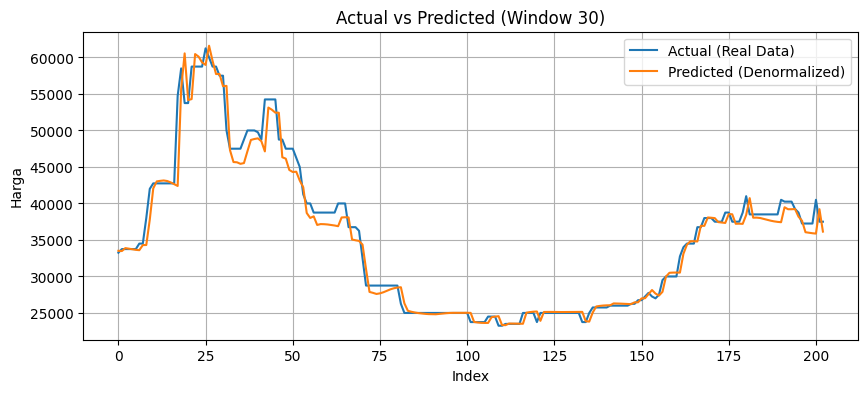

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Window_30.xlsx

[Proses] Training Window Size: 60 ...
   -> Selesai epoch : 324
   -> Best epoch    : 224 (val_loss=0.000248)
7/7 [==============================] - 4s 47ms/step
   -> MAPE Window 60: 2.4997%


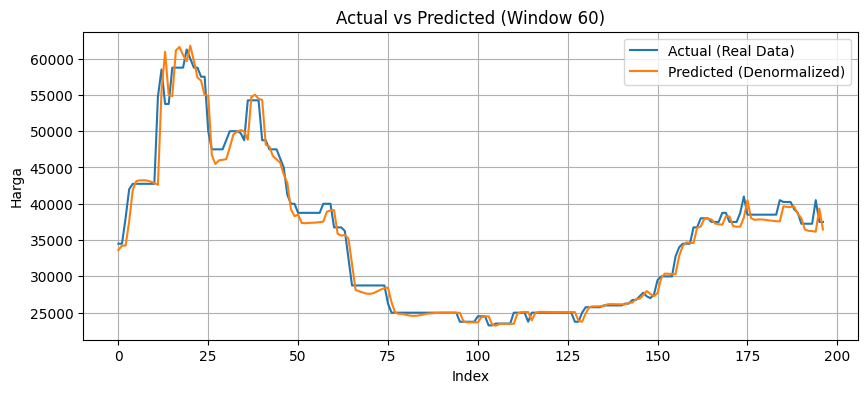

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Window_60.xlsx

[Proses] Training Window Size: 90 ...
   -> Selesai epoch : 366
   -> Best epoch    : 266 (val_loss=0.000385)
6/6 [==============================] - 6s 78ms/step
   -> MAPE Window 90: 2.3191%


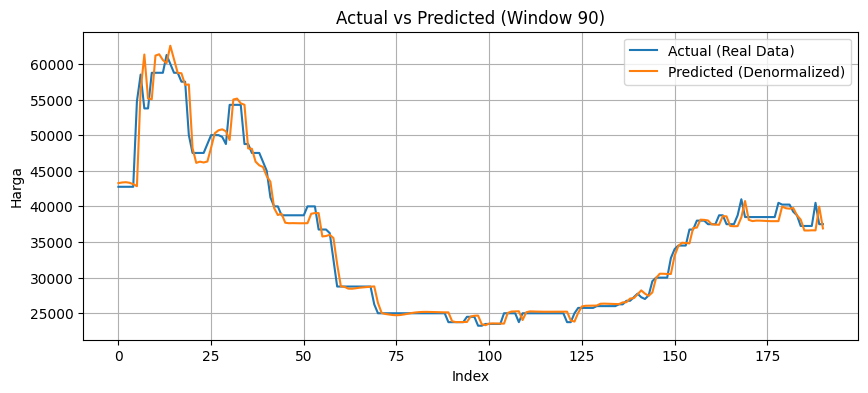

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Window_90.xlsx

   Window Size  MAPE (%)  Best Epoch  Best Loss
0           30  2.574564         211   0.000262
1           60  2.499682         224   0.000248
2           90  2.319136         266   0.000385


In [1]:
#WINDOW SIZE SAMA DENGAN DI BAB 3
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random as python_random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ==============================
# FIXED SEED
# ==============================
def reset_seeds():
    np.random.seed(42)
    python_random.seed(42)
    tf.random.set_seed(42)

reset_seeds()

# ==============================
# LOAD DATA
# ==============================
path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"
path_output_folder = r"E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA"
os.makedirs(path_output_folder, exist_ok=True)

if os.path.exists(path_file_input):
    df = pd.read_excel(path_file_input)
    print("✓ Data berhasil dimuat.")
else:
    raise FileNotFoundError("File tidak ditemukan!")

raw_data = df['Harga (Rp)'].values.reshape(-1, 1)
print(f"✓ Jumlah data: {len(raw_data)} baris")

# ==============================
# SLIDING WINDOW
# ==============================
def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

# ==============================
# BANGUN MODEL
# ==============================
def build_model_lstm(input_shape):
    tf.random.set_seed(42)
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')
    return model

# ==============================
# KONFIGURASI
# ==============================
scenario_windows = [30, 60, 90]   
FIXED_EPOCH = 500                 
FIXED_BATCH_SIZE = 30
early_stop = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

results = []

print("\n" + "="*50)
print("MULAI SKENARIO A (WINDOW BESAR)")
print("="*50)

# ==============================
# LOOP WINDOW SIZE
# ==============================
for win_size in scenario_windows:
    print(f"\n[Proses] Training Window Size: {win_size} ...")
    reset_seeds()

    # 1) Window di skala asli untuk menentukan split dan y_test asli
    X_full_raw, Y_full_raw = create_sliding_window(raw_data, win_size)
    train_size = int(len(X_full_raw) * 0.8)
    y_test_orig = Y_full_raw[train_size:]  # data uji asli dari Excel (belum normalisasi)

    # 2) Fit scaler HANYA pada segmen TRAIN (di skala asli) untuk hindari leakage
    #    Ambil sampai indeks train_size + win_size agar seluruh pasangan (X_train, y_train) ter-cover
    raw_train_segment = raw_data[:train_size + win_size]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(raw_train_segment)

    # 3) Transform seluruh data dengan scaler yang di-fit dari TRAIN (tanpa re-fit)
    scaled_data = scaler.transform(raw_data)

    # 4) Windowing pada data yang sudah di-scale
    X_full_scaled, Y_full_scaled = create_sliding_window(scaled_data, win_size)

    # 5) Bentuk train/test untuk model dari data ter-scale
    X_full_scaled = X_full_scaled.reshape(X_full_scaled.shape[0], X_full_scaled.shape[1], 1)
    X_train, X_test = X_full_scaled[:train_size], X_full_scaled[train_size:]
    y_train = Y_full_scaled[:train_size]

    # 6) Bangun model
    model = build_model_lstm((X_train.shape[1], 1))

    # 7) Training dengan validation_split agar early stopping memonitor val_loss
    history = model.fit(
        X_train, y_train,
        epochs=FIXED_EPOCH,
        batch_size=FIXED_BATCH_SIZE,
        callbacks=[early_stop],
        verbose=0,
        shuffle=False,
        validation_split=0.1
    )

    finished_epoch = len(history.history['loss'])
    best_epoch = np.argmin(history.history['val_loss']) + 1 if 'val_loss' in history.history else np.argmin(history.history['loss']) + 1
    best_loss = np.min(history.history['val_loss']) if 'val_loss' in history.history else np.min(history.history['loss'])

    print(f"   -> Selesai epoch : {finished_epoch}")
    print(f"   -> Best epoch    : {best_epoch} (val_loss={best_loss:.6f})")

    # 8) Prediksi pada X_test (scale) → inverse ke skala asli
    predictions_scaled = model.predict(X_test)
    predictions_real = scaler.inverse_transform(predictions_scaled)

    # 9) Hitung MAPE terhadap data asli 
    mape = mean_absolute_percentage_error(y_test_orig, predictions_real) * 100
    print(f"   -> MAPE Window {win_size}: {mape:.4f}%")

    results.append({
        'Window Size': win_size,
        'MAPE (%)': mape,
        'Best Epoch': best_epoch,
        'Best Loss': float(best_loss)
    })

    # ==============================
    # VISUALISASI
    # ==============================
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_orig, label='Actual (Real Data)')
    plt.plot(predictions_real, label='Predicted (Denormalized)')
    plt.title(f'Actual vs Predicted (Window {win_size})')
    plt.xlabel('Index')
    plt.ylabel('Harga')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ==============================
    # SIMPAN KE EXCEL
    # ==============================
    # Hindari div-zero pada error (%) jika ada nilai 0 di data asli
    y_test_safe = np.where(y_test_orig.flatten() == 0, np.finfo(float).eps, y_test_orig.flatten())
    err_pct = np.abs((y_test_orig.flatten() - predictions_real.flatten()) / y_test_safe) * 100

    out_df = pd.DataFrame({
        'Actual (Real)': y_test_orig.flatten(),
        'Predicted (Real)': predictions_real.flatten(),
        'Selisih': (y_test_orig.flatten() - predictions_real.flatten()),
        'Error (%)': err_pct
    })

    out_path = os.path.join(path_output_folder, f"Prediksi_Window_{win_size}.xlsx")
    out_df.to_excel(out_path, index=False)
    print(f"   ✓ Hasil disimpan ke: {out_path}")

# ==============================
# HASIL
# ==============================
print("\n" + "="*50)
results_df = pd.DataFrame(results)
print(results_df)
print("="*50)

✓ Data berhasil dimuat.
✓ Jumlah data: 1043 baris

MULAI UJI COBA NORMALISASI DATA

[Training] Window size = 7
   -> Selesai epoch : 424
   -> Best epoch    : 324 (val_loss=0.000165)
7/7 [==============================] - 2s 10ms/step
   -> MAPE          : 2.3022%


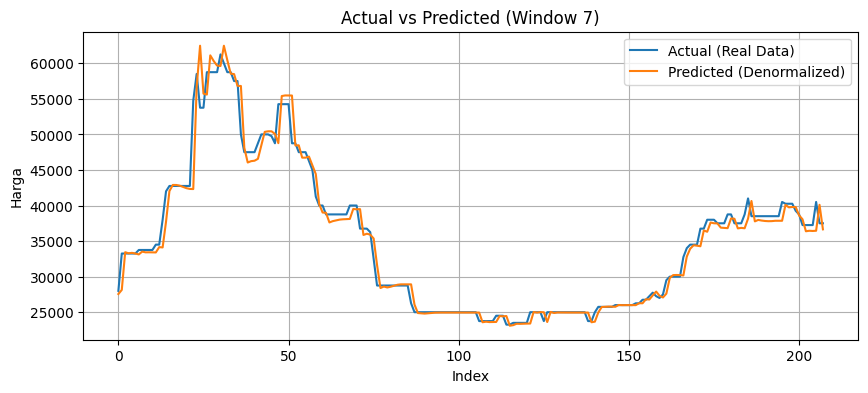

   ✓ File disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Window_7.xlsx

[Training] Window size = 14
   -> Selesai epoch : 500
   -> Best epoch    : 472 (val_loss=0.000266)
7/7 [==============================] - 2s 15ms/step
   -> MAPE          : 2.7264%


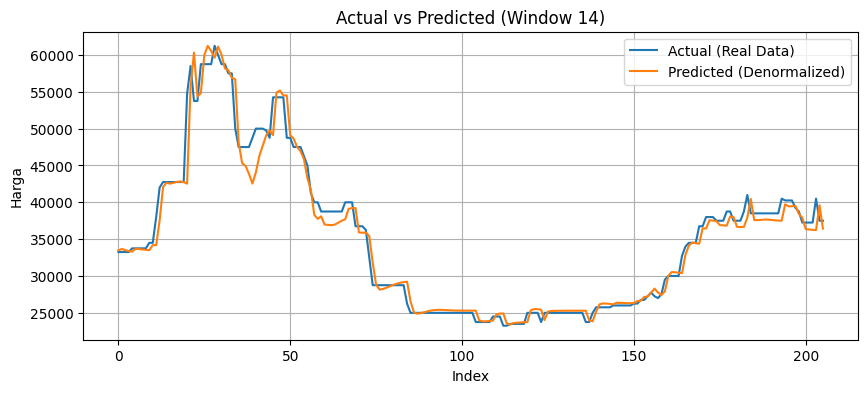

   ✓ File disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Window_14.xlsx

[Training] Window size = 21
   -> Selesai epoch : 345
   -> Best epoch    : 245 (val_loss=0.000266)
7/7 [==============================] - 1s 15ms/step
   -> MAPE          : 2.5131%


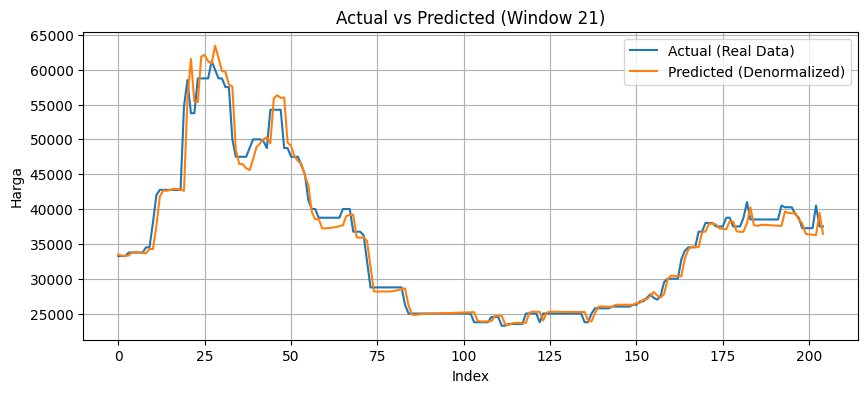

   ✓ File disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Window_21.xlsx

HASIL AKHIR
   Window Size  MAPE (%)  Best Epoch  Best Loss
0            7  2.302189         324   0.000165
1           14  2.726367         472   0.000266
2           21  2.513083         245   0.000266


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random as python_random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ==============================
# FIXED SEED
# ==============================
def reset_seeds():
    np.random.seed(42)
    python_random.seed(42)
    tf.random.set_seed(42)

reset_seeds()

# ==============================
# LOAD DATA
# ==============================
path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"
path_output_folder = r"E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA"
os.makedirs(path_output_folder, exist_ok=True)

if os.path.exists(path_file_input):
    df = pd.read_excel(path_file_input)
    print("✓ Data berhasil dimuat.")
else:
    raise FileNotFoundError("File tidak ditemukan!")

raw_data = df['Harga (Rp)'].values.reshape(-1, 1)
print(f"✓ Jumlah data: {len(raw_data)} baris")

# ==============================
# SLIDING WINDOW
# ==============================
def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

# ==============================
# BANGUN MODEL LSTM
# ==============================
def build_model_lstm(input_shape):
    tf.random.set_seed(42)
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')
    return model

# ==============================
# KONFIGURASI
# ==============================
scenario_windows = [7, 14, 21]
FIXED_EPOCH = 500
FIXED_BATCH_SIZE = 30

early_stop = EarlyStopping(
    monitor='val_loss',      # gunakan val_loss agar lebih robust
    patience=100,
    restore_best_weights=True
)

results = []

print("\n" + "="*50)
print("MULAI UJI COBA NORMALISASI DATA")
print("="*50)

# ==============================
# LOOP WINDOW SIZE
# ==============================
for win_size in scenario_windows:
    print(f"\n[Training] Window size = {win_size}")
    reset_seeds()

    # 1) Window dari data asli untuk menentukan split dan y_test asli
    X_full_raw, Y_full_raw = create_sliding_window(raw_data, win_size)
    train_size = int(len(X_full_raw) * 0.8)
    y_test_orig = Y_full_raw[train_size:]  # data testing asli (belum normalisasi)

    # 2) Fit scaler HANYA pada segmen TRAIN (di skala asli)
    #    Ambil data sampai indeks train_size + win_size agar seluruh pasangan (X_train, y_train) ter-cover
    raw_train_segment = raw_data[:train_size + win_size]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(raw_train_segment)

    # 3) Transform seluruh data dengan scaler yang di-fit dari TRAIN (tanpa re-fit)
    scaled_data = scaler.transform(raw_data)

    # 4) Windowing pada data yang sudah di-scale
    X_full_scaled, Y_full_scaled = create_sliding_window(scaled_data, win_size)

    # 5) Bentuk train/test untuk model dari data ter-scale
    X_full_scaled = X_full_scaled.reshape(X_full_scaled.shape[0], X_full_scaled.shape[1], 1)
    X_train, X_test = X_full_scaled[:train_size], X_full_scaled[train_size:]
    y_train = Y_full_scaled[:train_size]

    # 6) Bangun model
    model = build_model_lstm((X_train.shape[1], 1))

    # 7) Training (pakai validation_split agar early stopping memonitor val_loss)
    history = model.fit(
        X_train, y_train,
        epochs=FIXED_EPOCH,
        batch_size=FIXED_BATCH_SIZE,
        callbacks=[early_stop],
        verbose=0,
        shuffle=False,
        validation_split=0.1  # validasi diambil dari bagian tail train, tetap tanpa leakage
    )

    finished_epoch = len(history.history['loss'])
    best_epoch = np.argmin(history.history['val_loss']) + 1 if 'val_loss' in history.history else np.argmin(history.history['loss']) + 1
    best_loss = np.min(history.history['val_loss']) if 'val_loss' in history.history else np.min(history.history['loss'])
    print(f"   -> Selesai epoch : {finished_epoch}")
    print(f"   -> Best epoch    : {best_epoch} (val_loss={best_loss:.6f})")

    # 8) Prediksi pada X_test (scale), lalu inverse ke skala asli
    predictions_scaled = model.predict(X_test)
    predictions_real = scaler.inverse_transform(predictions_scaled)

    # 9) Hitung MAPE terhadap data asli
    mape = mean_absolute_percentage_error(y_test_orig, predictions_real) * 100
    print(f"   -> MAPE          : {mape:.4f}%")

    results.append({
        'Window Size': win_size,
        'MAPE (%)': mape,
        'Best Epoch': best_epoch,
        'Best Loss': float(best_loss)
    })

    # ==============================
    # VISUALISASI
    # ==============================
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_orig, label='Actual (Real Data)')
    plt.plot(predictions_real, label='Predicted (Denormalized)')
    plt.title(f'Actual vs Predicted (Window {win_size})')
    plt.xlabel('Index')
    plt.ylabel('Harga')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ==============================
    # SIMPAN HASIL KE EXCEL
    # ==============================
    # Hindari div-zero pada error (%) jika ada nilai 0 pada y_test_orig
    y_test_safe = np.where(y_test_orig.flatten() == 0, np.finfo(float).eps, y_test_orig.flatten())
    err_pct = np.abs((y_test_orig.flatten() - predictions_real.flatten()) / y_test_safe) * 100

    out_df = pd.DataFrame({
        'Actual (Real)': y_test_orig.flatten(),
        'Predicted (Real)': predictions_real.flatten(),
        'Selisih': y_test_orig.flatten() - predictions_real.flatten(),
        'Error (%)': err_pct
    })
    output_path = os.path.join(path_output_folder, f"Prediksi_Window_{win_size}.xlsx")
    out_df.to_excel(output_path, index=False)
    print(f"   ✓ File disimpan ke: {output_path}")

# ==============================
# RINGKASAN HASIL
# ==============================
print("\n" + "="*50)
print("HASIL AKHIR")
print("="*50)
df_results = pd.DataFrame(results)
print(df_results)
print("="*50)

✓ Data berhasil dimuat.
✓ Jumlah data: 1043 baris

MULAI FASE 2: SKENARIO B (Grid Epoch: 16, 30, 50)
Kondisi: Dengan Normalisasi, Tanpa EarlyStopping (epoch tetap), Val=tail train

[Training] Epoch = 16, Window = 90
   -> Selesai epoch : 16
   -> Best epoch    : 14 (val_loss=0.001218)
   -> MAPE          : 4.1190%


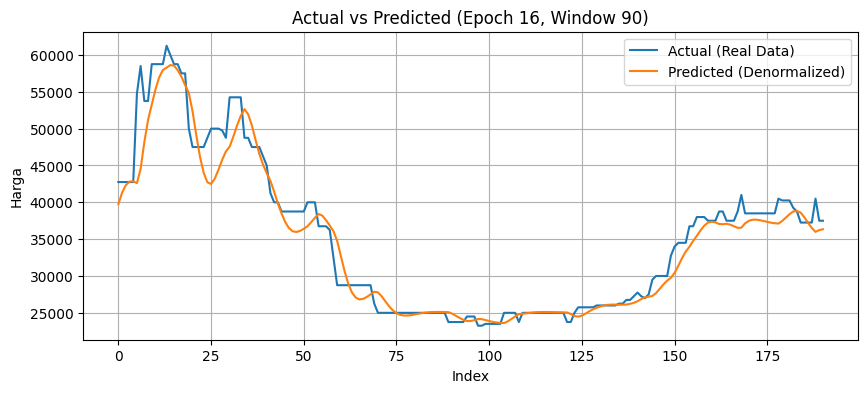

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Epoch_16_Window_90.xlsx

[Training] Epoch = 30, Window = 90
   -> Selesai epoch : 30
   -> Best epoch    : 30 (val_loss=0.000986)
   -> MAPE          : 3.7639%


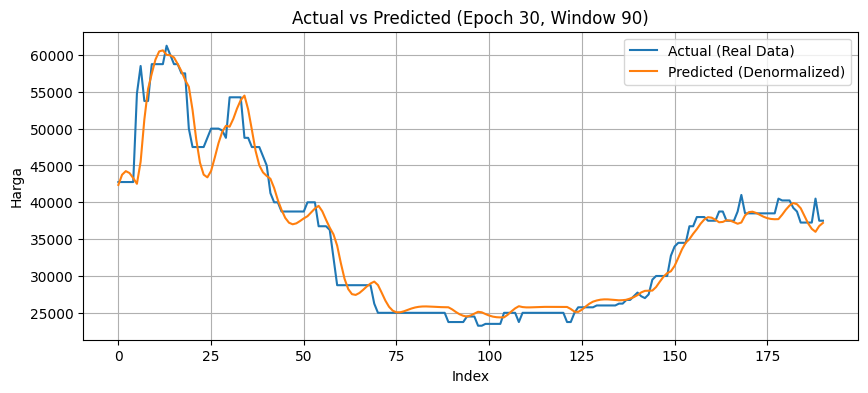

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Epoch_30_Window_90.xlsx

[Training] Epoch = 50, Window = 90
   -> Selesai epoch : 50
   -> Best epoch    : 47 (val_loss=0.000808)
   -> MAPE          : 3.3472%


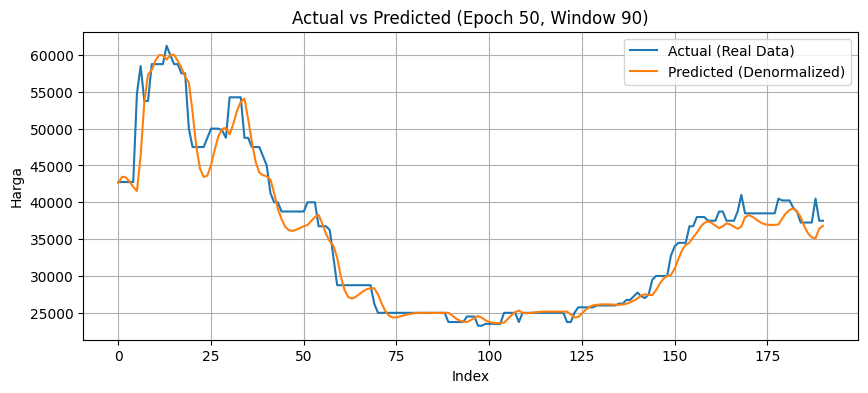

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Epoch_50_Window_90.xlsx

   Jumlah Epoch  Best Epoch (val)  Best Loss (val)  MAPE (%)
0            16                14         0.001218  4.118962
1            30                30         0.000986  3.763897
2            50                47         0.000808  3.347179
Kesimpulan: Epoch terbaik (grid) = 50 dengan MAPE 3.3472%


In [3]:
#MENCARI EPOCH TERBAIK SESUAI BAB 3
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random as python_random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def reset_seeds():
    np.random.seed(42)
    python_random.seed(42)
    tf.random.set_seed(42)

reset_seeds()

# ==============================
# PATH
# ==============================
path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"
path_output_folder = r"E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA"
os.makedirs(path_output_folder, exist_ok=True)

# ==============================
# LOAD DATA
# ==============================
if os.path.exists(path_file_input):
    df = pd.read_excel(path_file_input)
    print("✓ Data berhasil dimuat.")
else:
    raise FileNotFoundError("File tidak ditemukan.")

raw_data = df['Harga (Rp)'].values.reshape(-1, 1)
print(f"✓ Jumlah data: {len(raw_data)} baris")

# ==============================
# KONFIGURASI
# ==============================
FIXED_WINDOW_SIZE = 90
FIXED_BATCH_SIZE = 30
scenario_epochs = [16, 30, 50]  
VAL_RATIO = 0.1                

# ==============================
# FUNGSI
# ==============================
def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

def build_model_lstm(input_shape):
    tf.random.set_seed(42)
    model = Sequential()
    # 2 LSTM layer (selaras dengan kode window size)
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')
    return model

# ==============================
# SIAPKAN WINDOW DAN SPLIT DI SKALA ASLI
# ==============================
X_full_raw, Y_full_raw = create_sliding_window(raw_data, FIXED_WINDOW_SIZE)
train_size = int(len(X_full_raw) * 0.8)
y_test_orig = Y_full_raw[train_size:]  # data uji asli (sebelum normalisasi)

# Fit scaler HANYA pada segmen TRAIN (hindari leakage)
raw_train_segment = raw_data[:train_size + FIXED_WINDOW_SIZE]
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(raw_train_segment)

# Transform seluruh data dengan scaler train
scaled_data = scaler.transform(raw_data)

# Windowing pada data yang sudah di-scale
X_full_scaled, Y_full_scaled = create_sliding_window(scaled_data, FIXED_WINDOW_SIZE)

# Bentuk train/test untuk model
X_full_scaled = X_full_scaled.reshape(X_full_scaled.shape[0], X_full_scaled.shape[1], 1)
X_train_all, X_test = X_full_scaled[:train_size], X_full_scaled[train_size:]
y_train_all = Y_full_scaled[:train_size]

# Split validasi dari tail train (time-series friendly)
val_cut = int(len(X_train_all) * (1 - VAL_RATIO))
X_train, X_val = X_train_all[:val_cut], X_train_all[val_cut:]
y_train, y_val = y_train_all[:val_cut], y_train_all[val_cut:]

print("\n" + "="*60)
print("MULAI FASE 2: SKENARIO B (Grid Epoch: 16, 30, 50)")
print("Kondisi: Dengan Normalisasi, Tanpa EarlyStopping (epoch tetap), Val=tail train")
print("="*60)

results = []

# ==============================
# LOOP EPOCH TETAP
# ==============================
for epoch_count in scenario_epochs:
    print(f"\n[Training] Epoch = {epoch_count}, Window = {FIXED_WINDOW_SIZE}")
    reset_seeds()

    # Bangun model 2 LSTM layer
    model = build_model_lstm((X_train.shape[1], 1))

    # Training TANPA EarlyStopping (dipaksa selesai), tapi DENGAN validation_data
    history = model.fit(
        X_train, y_train,
        epochs=epoch_count,
        batch_size=FIXED_BATCH_SIZE,
        validation_data=(X_val, y_val),
        verbose=0,
        shuffle=False
    )

    # Ringkasan training
    finished_epoch = epoch_count
    if 'val_loss' in history.history:
        best_epoch = int(np.argmin(history.history['val_loss']) + 1)
        best_loss = float(np.min(history.history['val_loss']))
        print(f"   -> Selesai epoch : {finished_epoch}")
        print(f"   -> Best epoch    : {best_epoch} (val_loss={best_loss:.6f})")
    else:
        best_epoch = int(np.argmin(history.history['loss']) + 1)
        best_loss = float(np.min(history.history['loss']))
        print(f"   -> Selesai epoch : {finished_epoch}")
        print(f"   -> Best epoch    : {best_epoch} (loss={best_loss:.6f})")

    # Evaluasi di TEST (skala asli)
    predictions_scaled = model.predict(X_test, verbose=0)
    predictions_real = scaler.inverse_transform(predictions_scaled)

    mape = mean_absolute_percentage_error(y_test_orig, predictions_real) * 100
    print(f"   -> MAPE          : {mape:.4f}%")

    # Simpan hasil untuk ringkasan
    results.append({
        'Jumlah Epoch': epoch_count,
        'Best Epoch (val)': best_epoch,
        'Best Loss (val)': best_loss,
        'MAPE (%)': float(mape)
    })

    # ==============================
    # VISUALISASI
    # ==============================
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_orig, label='Actual (Real Data)')
    plt.plot(predictions_real, label='Predicted (Denormalized)')
    plt.title(f'Actual vs Predicted (Epoch {epoch_count}, Window {FIXED_WINDOW_SIZE})')
    plt.xlabel('Index')
    plt.ylabel('Harga')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ==============================
    # SIMPAN KE EXCEL (20% test)
    # ==============================
    y_test_safe = np.where(y_test_orig.flatten() == 0, np.finfo(float).eps, y_test_orig.flatten())
    err_pct = np.abs((y_test_orig.flatten() - predictions_real.flatten()) / y_test_safe) * 100

    out_df = pd.DataFrame({
        'Actual (Real)': y_test_orig.flatten(),
        'Predicted (Real)': predictions_real.flatten(),
        'Selisih': (y_test_orig.flatten() - predictions_real.flatten()),
        'Error (%)': err_pct
    })
    out_path = os.path.join(path_output_folder, f"Prediksi_Epoch_{epoch_count}_Window_{FIXED_WINDOW_SIZE}.xlsx")
    out_df.to_excel(out_path, index=False)
    print(f"   ✓ Hasil disimpan ke: {out_path}")

# ==============================
# HASIL RINGKASAN
# ==============================
print("\n" + "="*60)
results_df = pd.DataFrame(results)
print(results_df)
print("="*60)

# Tampilkan kesimpulan MAPE terendah
best_result = results_df.loc[results_df['MAPE (%)'].idxmin()]
best_epoch = int(best_result['Jumlah Epoch'])
print(f"Kesimpulan: Epoch terbaik (grid) = {best_epoch} dengan MAPE {best_result['MAPE (%)']:.4f}%")

✓ Data berhasil dimuat.
✓ Jumlah baris asli (raw): 1043
✓ Jumlah sampel window: 953 (window=90)
✓ Data ternormalisasi (0-1).
Train: (685, 90, 1), Val: (77, 90, 1), Test: (191, 90, 1)

MULAI PENCARIAN EPOCH OTOMATIS (EarlyStopping)
Max Epoch 300 | Patience 30 | min_delta 1e-05 | Batch 30
Epoch 1/300
23/23 [==============================] - 18s 505ms/step - loss: 0.0105 - val_loss: 0.0029 - lr: 0.0010
Epoch 2/300
23/23 [==============================] - 10s 439ms/step - loss: 0.0068 - val_loss: 0.0077 - lr: 0.0010
Epoch 3/300
23/23 [==============================] - 11s 473ms/step - loss: 0.0072 - val_loss: 0.0048 - lr: 0.0010
Epoch 4/300
23/23 [==============================] - 10s 445ms/step - loss: 0.0070 - val_loss: 0.0061 - lr: 0.0010
Epoch 5/300
23/23 [==============================] - 10s 436ms/step - loss: 0.0068 - val_loss: 0.0043 - lr: 0.0010
Epoch 6/300
23/23 [==============================] - 10s 442ms/step - loss: 0.0071 - val_loss: 0.0028 - lr: 0.0010
Epoch 7/300
23/23 [===

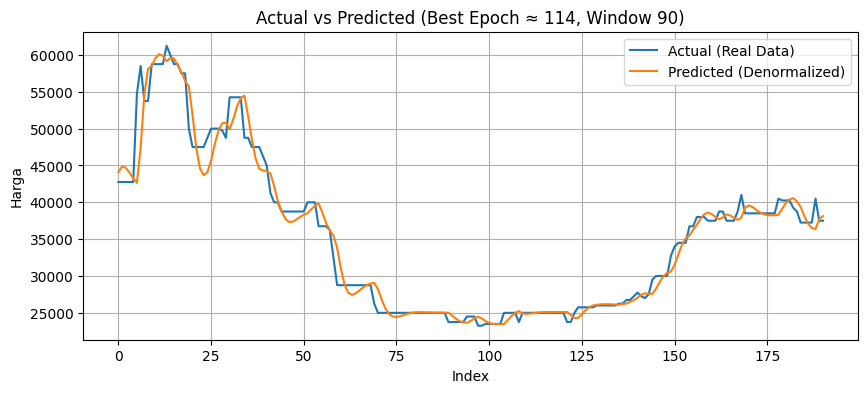

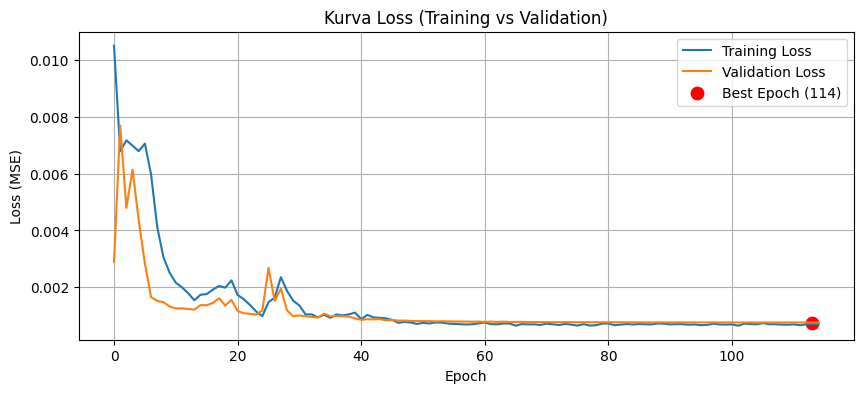

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_AutoEpoch_Window_90.xlsx

RINGKASAN OTOMATIS (EARLY STOPPING)
   Window Size  Max Epoch  Finished Epoch  Best Epoch (val)  Best Val Loss  \
0           90        300             115               114       0.000764   

   Last Loss  Last Val Loss  Batch Size  MAPE (%)  
0   0.000703       0.000764          30   2.92425  


In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random as python_random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ==============================
# 1) FIXED SEED
# ==============================
def reset_seeds():
    np.random.seed(42)
    python_random.seed(42)
    tf.random.set_seed(42)

reset_seeds()

# ==============================
# 2) PATH & LOAD
# ==============================
path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"
path_output_folder = r"E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA"
os.makedirs(path_output_folder, exist_ok=True)

if os.path.exists(path_file_input):
    df = pd.read_excel(path_file_input)
    print("✓ Data berhasil dimuat.")
else:
    raise FileNotFoundError("File tidak ditemukan.")

raw_data = df['Harga (Rp)'].values.reshape(-1, 1)
print(f"✓ Jumlah baris asli (raw): {len(raw_data)}")

# ==============================
# 3) KONFIGURASI
# ==============================
FIXED_WINDOW_SIZE = 90
FIXED_BATCH_SIZE = 30
VAL_RATIO = 0.1

# Otomatis epoch via EarlyStopping (tanpa daftar epoch tetap)
MAX_EPOCHS = 300        # boleh turunkan ke 300 jika runtime jadi concern
PATIENCE = 30           # boleh turunkan ke 25–30
MIN_DELTA = 1e-5        # abaikan perbaikan mikro agar berhenti lebih cepat

# ==============================
# 4) UTIL
# ==============================
def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

def build_model_lstm(input_shape):
    tf.random.set_seed(42)
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')
    return model

# ==============================
# 5) SPLIT & SCALING (ANTI-LEAKAGE)
# ==============================
X_full_raw, Y_full_raw = create_sliding_window(raw_data, FIXED_WINDOW_SIZE)
print(f"✓ Jumlah sampel window: {len(X_full_raw)} (window={FIXED_WINDOW_SIZE})")

train_size = int(len(X_full_raw) * 0.8)
y_test_orig = Y_full_raw[train_size:]  # untuk evaluasi di skala asli

# Fit scaler HANYA pada segmen TRAIN (hindari leakage)
raw_train_segment = raw_data[:train_size + FIXED_WINDOW_SIZE]
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(raw_train_segment)

# Transform seluruh data pakai scaler TRAIN
scaled_data = scaler.transform(raw_data)
print("✓ Data ternormalisasi (0-1).")

# Windowing pada data ter-scale
X_full_scaled, Y_full_scaled = create_sliding_window(scaled_data, FIXED_WINDOW_SIZE)
X_full_scaled = X_full_scaled.reshape(X_full_scaled.shape[0], X_full_scaled.shape[1], 1)

# Train/Test berbasis window
X_train_all, X_test = X_full_scaled[:train_size], X_full_scaled[train_size:]
y_train_all = Y_full_scaled[:train_size]

# Validasi = tail dari TRAIN (time-series friendly)
val_cut = int(len(X_train_all) * (1 - VAL_RATIO))
X_train, X_val = X_train_all[:val_cut], X_train_all[val_cut:]
y_train, y_val = y_train_all[:val_cut], y_train_all[val_cut:]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# ==============================
# 6) TRAINING OTOMATIS (EARLY STOPPING)
# ==============================
print("\n" + "="*60)
print("MULAI PENCARIAN EPOCH OTOMATIS (EarlyStopping)")
print(f"Max Epoch {MAX_EPOCHS} | Patience {PATIENCE} | min_delta {MIN_DELTA} | Batch {FIXED_BATCH_SIZE}")
print("="*60)

reset_seeds()
model = build_model_lstm((X_train.shape[1], 1))

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    min_delta=MIN_DELTA,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=max(PATIENCE // 3, 5),
    min_lr=1e-5,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=MAX_EPOCHS,
    batch_size=FIXED_BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1,
    shuffle=False
)

# Ringkasan training
train_loss = history.history['loss']
val_loss = history.history['val_loss']
finished_epoch = len(train_loss)
best_epoch = int(np.argmin(val_loss) + 1)
best_val_loss = float(np.min(val_loss))
last_loss = float(train_loss[-1])
last_val_loss = float(val_loss[-1])

print(f"\n   -> Selesai epoch : {finished_epoch}")
print(f"   -> Best epoch    : {best_epoch} (val_loss={best_val_loss:.6f})")
print(f"   -> Last loss     : {last_loss:.6f} | Last val_loss : {last_val_loss:.6f}")

# ==============================
# 7) EVALUASI DI TEST (DENORMALIZED)
# ==============================
predictions_scaled = model.predict(X_test, verbose=1)
predictions_real = scaler.inverse_transform(predictions_scaled)

mape = mean_absolute_percentage_error(y_test_orig.ravel(), predictions_real.ravel()) * 100
print(f"   -> MAPE          : {mape:.4f}%")

# ==============================
# 8) VISUALISASI
# ==============================
plt.figure(figsize=(10, 4))
plt.plot(y_test_orig, label='Actual (Real Data)')
plt.plot(predictions_real, label='Predicted (Denormalized)')
plt.title(f'Actual vs Predicted (Best Epoch ≈ {best_epoch}, Window {FIXED_WINDOW_SIZE})')
plt.xlabel('Index')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.show()

# Kurva loss
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.scatter(best_epoch-1, best_val_loss, color='red', s=80, label=f'Best Epoch ({best_epoch})')
plt.title('Kurva Loss (Training vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# ==============================
# 9) SIMPAN KE EXCEL (20% test)
# ==============================
y_test_safe = np.where(y_test_orig.flatten() == 0, np.finfo(float).eps, y_test_orig.flatten())
err_pct = np.abs((y_test_orig.flatten() - predictions_real.flatten()) / y_test_safe) * 100

out_df = pd.DataFrame({
    'Actual (Real)': y_test_orig.flatten(),
    'Predicted (Real)': predictions_real.flatten(),
    'Selisih': (y_test_orig.flatten() - predictions_real.flatten()),
    'Error (%)': err_pct
})
out_path = os.path.join(path_output_folder, f"Prediksi_AutoEpoch_Window_{FIXED_WINDOW_SIZE}.xlsx")
out_df.to_excel(out_path, index=False)
print(f"   ✓ Hasil disimpan ke: {out_path}")

# ==============================
# 10) RINGKASAN
# ==============================
summary = pd.DataFrame([{
    'Window Size': int(FIXED_WINDOW_SIZE),
    'Max Epoch': int(MAX_EPOCHS),
    'Finished Epoch': int(finished_epoch),
    'Best Epoch (val)': int(best_epoch),
    'Best Val Loss': float(best_val_loss),
    'Last Loss': float(last_loss),
    'Last Val Loss': float(last_val_loss),
    'Batch Size': int(FIXED_BATCH_SIZE),
    'MAPE (%)': float(mape)
}])
print("\n" + "="*60)
print("RINGKASAN OTOMATIS (EARLY STOPPING)")
print("="*60)
print(summary)

✓ Data berhasil dimuat.
✓ Data ternormalisasi (0-1).

[Info] Dataset Window Size: 90
----------------------------------------
Total Data: 953 | Latih: 762 | Uji: 191
----------------------------------------

MULAI FASE 2: SKENARIO C (Mencari Batch Size Terbaik)
Konfigurasi: Window 90 | Epoch 50

[Proses] Training dengan Batch Size: 16 ...
6/6 [==============================] - 3s 150ms/step
   -> Selesai. Hasil MAPE: 5.5420%


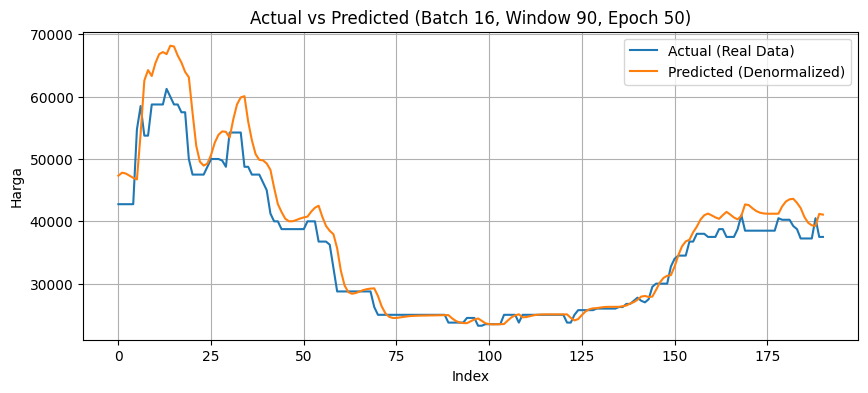

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Batch_16_Window_90_Epoch_50.xlsx

[Proses] Training dengan Batch Size: 30 ...
6/6 [==============================] - 3s 146ms/step
   -> Selesai. Hasil MAPE: 3.3472%


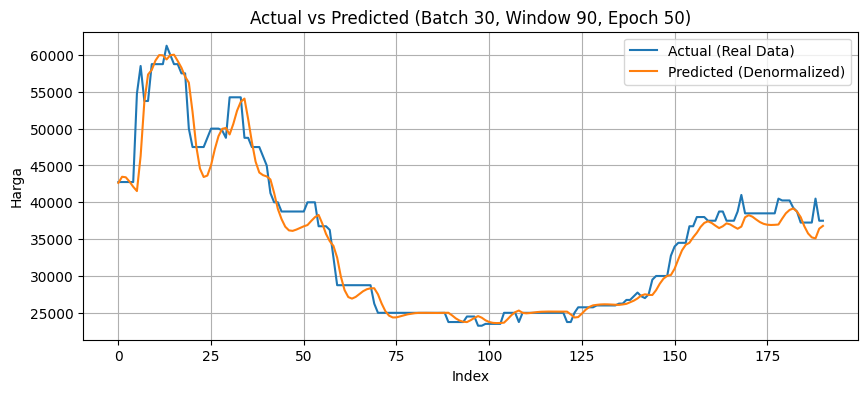

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Batch_30_Window_90_Epoch_50.xlsx

[Proses] Training dengan Batch Size: 64 ...
6/6 [==============================] - 2s 147ms/step
   -> Selesai. Hasil MAPE: 3.3422%


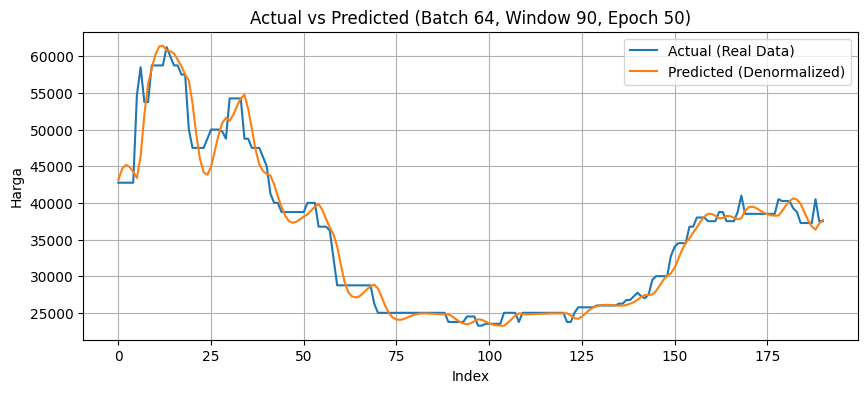

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Batch_64_Window_90_Epoch_50.xlsx

   Batch Size  MAPE (%)
0          16  5.541996
1          30  3.347179
2          64  3.342225
------------------------------------------------------------
KESIMPULAN FINAL (KONFIGURASI MODEL TERBAIK):
1. Normalisasi : YA (MinMaxScaler; fit di segmen TRAIN, transform 100% data)
2. Window Size : 90
3. Epoch       : 50
4. Batch Size  : 64
MAPE Terendah  : 3.3422%


In [7]:
#MENCARI BATCH SIZE TERBAIK SESUAI BAB 3
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random as python_random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ==============================
# SEEDS
# ==============================
def reset_seeds():
    np.random.seed(42)
    python_random.seed(42)
    tf.random.set_seed(42)

reset_seeds()

# ==============================
# PATH
# ==============================
path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"
path_output_folder = r"E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA"
os.makedirs(path_output_folder, exist_ok=True)

# ==============================
# LOAD DATA
# ==============================
if os.path.exists(path_file_input):
    df = pd.read_excel(path_file_input)
    print("✓ Data berhasil dimuat.")
else:
    raise FileNotFoundError("File tidak ditemukan.")

raw_data = df['Harga (Rp)'].values.reshape(-1, 1)

# ==============================
# KONFIGURASI
# ==============================
FIXED_WINDOW_SIZE = 90
FIXED_EPOCH = 50
scenario_batch_sizes = [16, 30, 64]
VAL_RATIO = 0.1

# ==============================
# FUNGSI
# ==============================
def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

def build_model_lstm(input_shape):
    tf.random.set_seed(42)
    model = Sequential()
    # 2 LSTM layer
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')
    return model

# ==============================
# WINDOW DI SKALA ASLI (UNTUK AKTUAL)
# ==============================
X_full_raw, Y_full_raw = create_sliding_window(raw_data, FIXED_WINDOW_SIZE)
train_size = int(len(X_full_raw) * 0.8)
y_test_orig = Y_full_raw[train_size:]  # data uji asli (sebelum normalisasi)

# ==============================
# FIT SCALER HANYA PADA TRAIN (HINDARI LEAKAGE)
# ==============================
raw_train_segment = raw_data[:train_size + FIXED_WINDOW_SIZE]
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(raw_train_segment)

# Transform seluruh data dengan scaler yang di-fit dari TRAIN
scaled_data = scaler.transform(raw_data)
print("✓ Data ternormalisasi (0-1).")

# ==============================
# WINDOWING PADA DATA TER-SCALE
# ==============================
X_full_scaled, Y_full_scaled = create_sliding_window(scaled_data, FIXED_WINDOW_SIZE)
X_full_scaled = X_full_scaled.reshape(X_full_scaled.shape[0], X_full_scaled.shape[1], 1)

# Split 80:20 (berbasis window)
X_train_all, X_test = X_full_scaled[:train_size], X_full_scaled[train_size:]
y_train_all = Y_full_scaled[:train_size]

# Split validasi dari tail train
val_cut = int(len(X_train_all) * (1 - VAL_RATIO))
X_train, X_val = X_train_all[:val_cut], X_train_all[val_cut:]
y_train, y_val = y_train_all[:val_cut], y_train_all[val_cut:]

# ==============================
# INFO DATA
# ==============================
print(f"\n[Info] Dataset Window Size: {FIXED_WINDOW_SIZE}")
print("----------------------------------------")
print(f"Total Data: {len(X_full_scaled)} | Latih: {len(X_train_all)} | Uji: {len(X_test)}")
print("----------------------------------------")

print("\n" + "="*60)
print("MULAI FASE 2: SKENARIO C (Mencari Batch Size Terbaik)")
print(f"Konfigurasi: Window {FIXED_WINDOW_SIZE} | Epoch {FIXED_EPOCH}")
print("="*60)

results = []

# ==============================
# LOOP BATCH SIZE
# ==============================
for batch_count in scenario_batch_sizes:
    print(f"\n[Proses] Training dengan Batch Size: {batch_count} ...")
    reset_seeds()

    # Bangun model
    model = build_model_lstm((X_train.shape[1], 1))

    # Training TANPA EarlyStopping (epoch tetap), DENGAN validation_data
    history = model.fit(
        X_train, y_train,
        epochs=FIXED_EPOCH,
        batch_size=batch_count,
        validation_data=(X_val, y_val),
        verbose=0,
        shuffle=False
    )

    # Prediksi pada TEST (progress)
    predictions_scaled = model.predict(X_test, verbose=1)
    predictions_real = scaler.inverse_transform(predictions_scaled)

    # MAPE terhadap data uji asli
    mape = mean_absolute_percentage_error(y_test_orig, predictions_real) * 100
    print(f"   -> Selesai. Hasil MAPE: {mape:.4f}%")

    # Simpan ringkasan
    results.append({'Batch Size': batch_count, 'MAPE (%)': float(mape)})

    # ==============================
    # VISUALISASI: Actual vs Predicted (Denormalized)
    # ==============================
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_orig, label='Actual (Real Data)')
    plt.plot(predictions_real, label='Predicted (Denormalized)')
    plt.title(f'Actual vs Predicted (Batch {batch_count}, Window {FIXED_WINDOW_SIZE}, Epoch {FIXED_EPOCH})')
    plt.xlabel('Index')
    plt.ylabel('Harga')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ==============================
    # SIMPAN KE EXCEL (20% test)
    # ==============================
    y_test_safe = np.where(y_test_orig.flatten() == 0, np.finfo(float).eps, y_test_orig.flatten())
    err_pct = np.abs((y_test_orig.flatten() - predictions_real.flatten()) / y_test_safe) * 100

    out_df = pd.DataFrame({
        'Actual (Real)': y_test_orig.flatten(),
        'Predicted (Real)': predictions_real.flatten(),
        'Selisih': (y_test_orig.flatten() - predictions_real.flatten()),
        'Error (%)': err_pct
    })
    out_path = os.path.join(path_output_folder, f"Prediksi_Batch_{batch_count}_Window_{FIXED_WINDOW_SIZE}_Epoch_{FIXED_EPOCH}.xlsx")
    out_df.to_excel(out_path, index=False)
    print(f"   ✓ Hasil disimpan ke: {out_path}")

# ==============================
# HASIL AKHIR FINAL (KONFIGURASI TERBAIK)
# ==============================
print("\n" + "="*60)
results_df = pd.DataFrame(results)
print(results_df)

best_result = results_df.loc[results_df['MAPE (%)'].idxmin()]
best_batch = int(best_result['Batch Size'])

print("-" * 60)
print("KESIMPULAN FINAL (KONFIGURASI MODEL TERBAIK):")
print(f"1. Normalisasi : YA (MinMaxScaler; fit di segmen TRAIN, transform 100% data)")
print(f"2. Window Size : {FIXED_WINDOW_SIZE}")
print(f"3. Epoch       : {FIXED_EPOCH}")
print(f"4. Batch Size  : {best_batch}")
print(f"MAPE Terendah  : {best_result['MAPE (%)']:.4f}%")
print("="*60)

✓ Data berhasil dimuat.
✓ Jumlah baris asli (raw): 1043
✓ Sistem akan menguji otomatis Batch Size: [16, 32, 48, 64, 80, 96, 112, 128]
✓ Jumlah sampel window: 953 (window=90)
✓ Data ternormalisasi (0-1).

[Info] Dataset Window Size: 90
----------------------------------------
Total Window Samples: 953 | Train: 762 | Val: 77 | Test: 191
----------------------------------------

MULAI FASE 2: SKENARIO C (Scan Batch Size, Epoch Tetap)
Konfigurasi: Window 90 | Epoch 50 | Val tail 10%

[Scanning] Menguji Batch Size: 16 ...
   -> Selesai epoch : 50
   -> Best epoch    : 46 (val_loss=0.000737)
   -> Last loss     : 0.001218 | Last val_loss : 0.001011
   -> MAPE          : 5.5420%


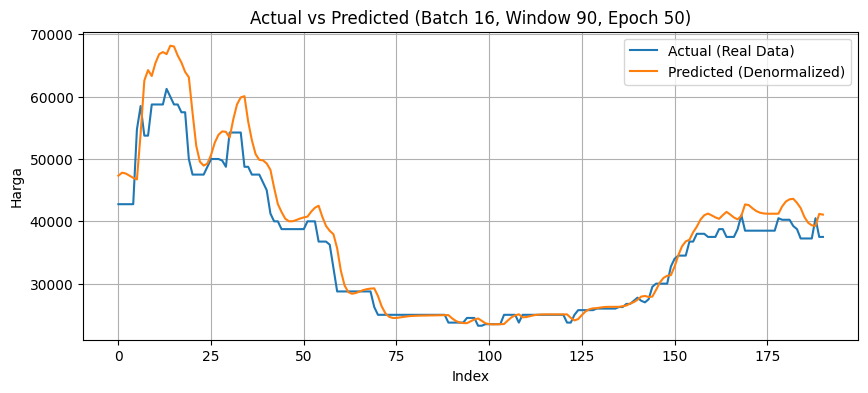

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Batch_16_Window_90_Epoch_50.xlsx

[Scanning] Menguji Batch Size: 32 ...
   -> Selesai epoch : 50
   -> Best epoch    : 41 (val_loss=0.000963)
   -> Last loss     : 0.001380 | Last val_loss : 0.000972
   -> MAPE          : 4.4421%


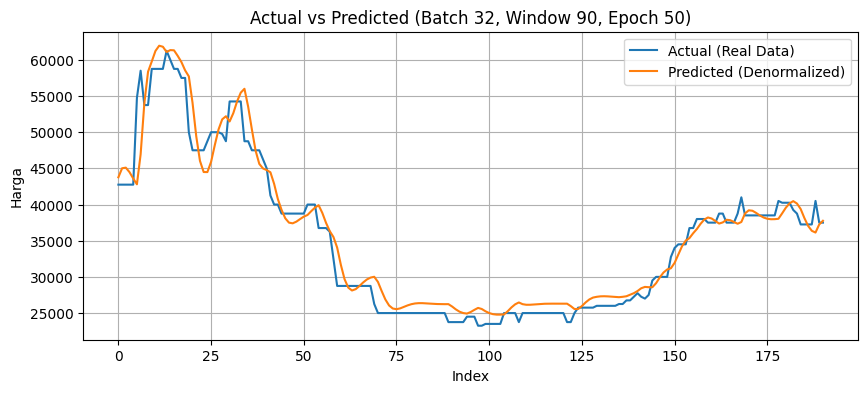

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Batch_32_Window_90_Epoch_50.xlsx

[Scanning] Menguji Batch Size: 48 ...
   -> Selesai epoch : 50
   -> Best epoch    : 49 (val_loss=0.000910)
   -> Last loss     : 0.001047 | Last val_loss : 0.000984
   -> MAPE          : 3.5157%


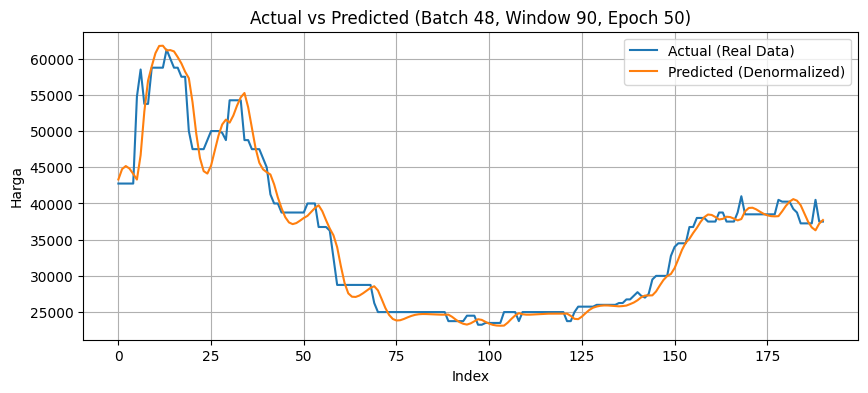

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Batch_48_Window_90_Epoch_50.xlsx

[Scanning] Menguji Batch Size: 64 ...
   -> Selesai epoch : 50
   -> Best epoch    : 49 (val_loss=0.000944)
   -> Last loss     : 0.000899 | Last val_loss : 0.000987
   -> MAPE          : 3.3422%


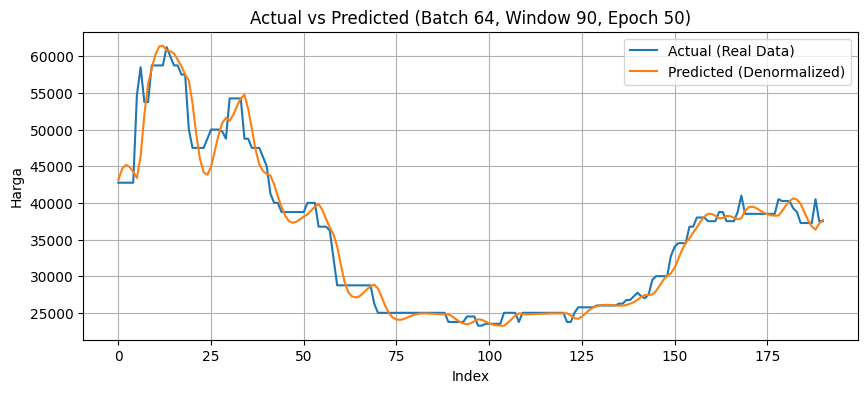

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Batch_64_Window_90_Epoch_50.xlsx

[Scanning] Menguji Batch Size: 80 ...
   -> Selesai epoch : 50
   -> Best epoch    : 50 (val_loss=0.001104)
   -> Last loss     : 0.000983 | Last val_loss : 0.001104
   -> MAPE          : 3.7553%


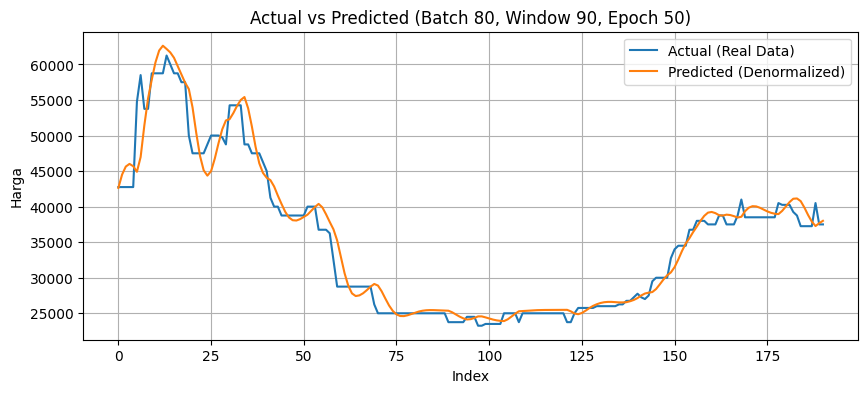

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Batch_80_Window_90_Epoch_50.xlsx

[Scanning] Menguji Batch Size: 96 ...
   -> Selesai epoch : 50
   -> Best epoch    : 49 (val_loss=0.001116)
   -> Last loss     : 0.000912 | Last val_loss : 0.001121
   -> MAPE          : 3.5293%


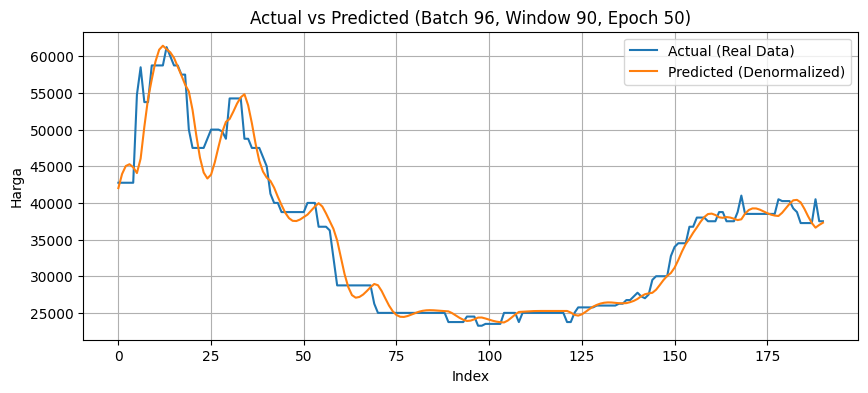

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Batch_96_Window_90_Epoch_50.xlsx

[Scanning] Menguji Batch Size: 112 ...
   -> Selesai epoch : 50
   -> Best epoch    : 50 (val_loss=0.001093)
   -> Last loss     : 0.001564 | Last val_loss : 0.001093
   -> MAPE          : 3.6362%


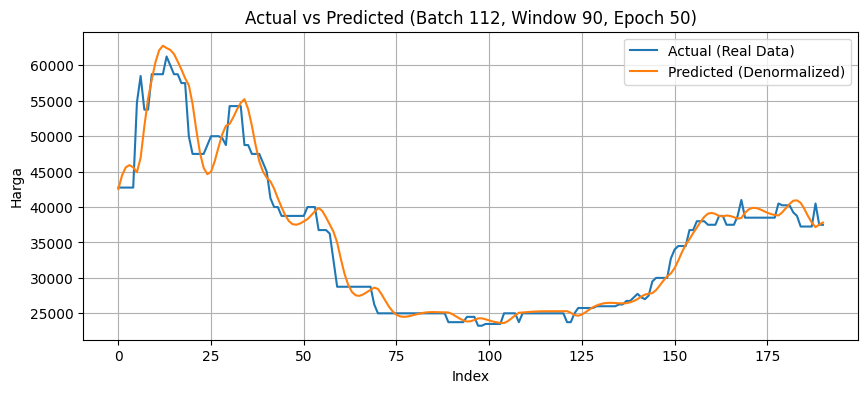

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Batch_112_Window_90_Epoch_50.xlsx

[Scanning] Menguji Batch Size: 128 ...
   -> Selesai epoch : 50
   -> Best epoch    : 50 (val_loss=0.001150)
   -> Last loss     : 0.001134 | Last val_loss : 0.001150
   -> MAPE          : 4.0446%


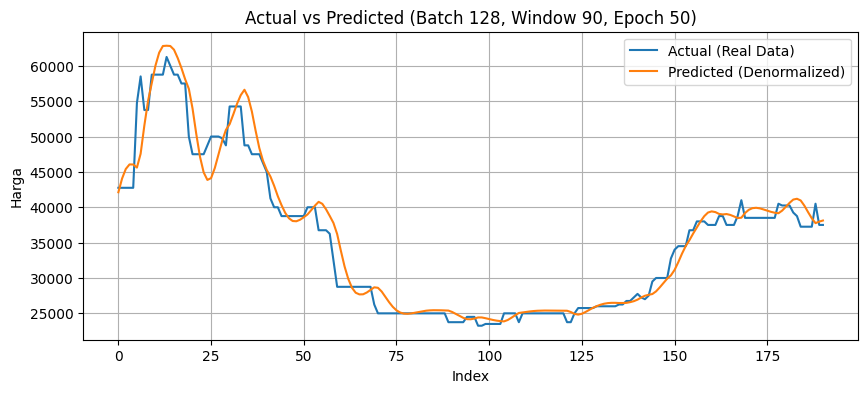

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Batch_128_Window_90_Epoch_50.xlsx

   Batch Size  Best Epoch (val)  Best Val Loss  Last Loss  Last Val Loss  \
3          64                49       0.000944   0.000899       0.000987   
2          48                49       0.000910   0.001047       0.000984   
5          96                49       0.001116   0.000912       0.001121   
6         112                50       0.001093   0.001564       0.001093   
4          80                50       0.001104   0.000983       0.001104   
7         128                50       0.001150   0.001134       0.001150   
1          32                41       0.000963   0.001380       0.000972   
0          16                46       0.000737   0.001218       0.001011   

   MAPE (%)  
3  3.342225  
2  3.515694  
5  3.529260  
6  3.636242  
4  3.755323  
7  4.044643  
1  4.442092  
0  5.541996  
------------------------------------------------------------
KESIMPULAN FASE 1 

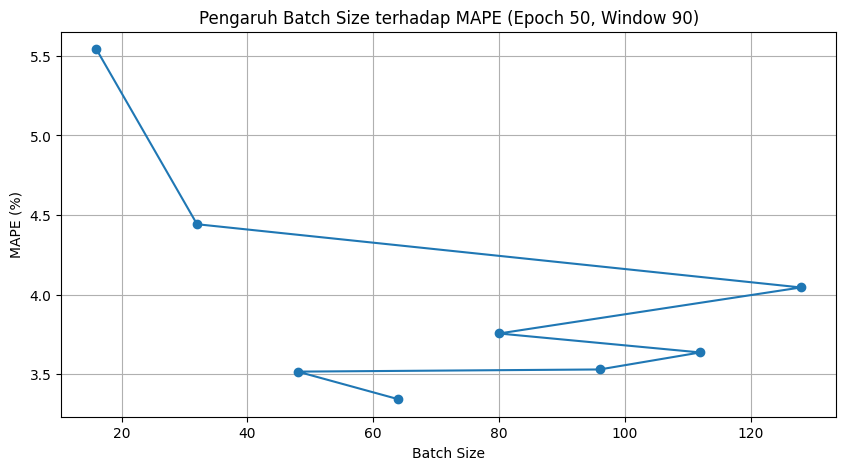

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random as python_random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ==============================
# FIXED SEED
# ==============================
def reset_seeds():
    np.random.seed(42)
    python_random.seed(42)
    tf.random.set_seed(42)

reset_seeds()

# ==============================
# PATH
# ==============================
path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"
path_output_folder = r"E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA"
os.makedirs(path_output_folder, exist_ok=True)

# ==============================
# LOAD DATA
# ==============================
if os.path.exists(path_file_input):
    df = pd.read_excel(path_file_input)
    print("✓ Data berhasil dimuat.")
else:
    raise FileNotFoundError("File tidak ditemukan.")

raw_data = df['Harga (Rp)'].values.reshape(-1, 1)
print(f"✓ Jumlah baris asli (raw): {len(raw_data)}")

# ==============================
# KONFIGURASI
# ==============================
FIXED_WINDOW_SIZE = 90         # gunakan pemenang window
FIXED_EPOCH = 50               # gunakan pemenang epoch
VAL_RATIO = 0.1                # validasi diambil dari tail train (time-series friendly)

# Auto-scan batch size 16..128 step 16
START_BATCH = 16
STOP_BATCH = 128
STEP_BATCH = 16
automatic_batch_sizes = list(range(START_BATCH, STOP_BATCH + 1, STEP_BATCH))
print(f"✓ Sistem akan menguji otomatis Batch Size: {automatic_batch_sizes}")

# ==============================
# FUNGSI
# ==============================
def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

def build_model_lstm(input_shape):
    tf.random.set_seed(42)
    model = Sequential()
    # Arsitektur konsisten
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')
    return model

# ==============================
# PERSIAPAN DATA (ANTI-LEAKAGE + INFO)
# ==============================
# Window di skala asli untuk split dan y_test asli
X_full_raw, Y_full_raw = create_sliding_window(raw_data, FIXED_WINDOW_SIZE)
print(f"✓ Jumlah sampel window: {len(X_full_raw)} (window={FIXED_WINDOW_SIZE})")

train_size = int(len(X_full_raw) * 0.8)
y_test_orig = Y_full_raw[train_size:]  # data uji asli (belum normalisasi)

# Fit scaler HANYA pada segmen TRAIN (hindari leakage)
raw_train_segment = raw_data[:train_size + FIXED_WINDOW_SIZE]
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(raw_train_segment)

# Transform seluruh data dengan scaler yang di-fit dari TRAIN
scaled_data = scaler.transform(raw_data)
print("✓ Data ternormalisasi (0-1).")

# Windowing pada data ter-scale
X_full_scaled, Y_full_scaled = create_sliding_window(scaled_data, FIXED_WINDOW_SIZE)

# Bentuk train/val/test (berbasis window)
X_full_scaled = X_full_scaled.reshape(X_full_scaled.shape[0], X_full_scaled.shape[1], 1)
X_train_all, X_test = X_full_scaled[:train_size], X_full_scaled[train_size:]
y_train_all = Y_full_scaled[:train_size]

val_cut = int(len(X_train_all) * (1 - VAL_RATIO))
X_train, X_val = X_train_all[:val_cut], X_train_all[val_cut:]
y_train, y_val = y_train_all[:val_cut], y_train_all[val_cut:]

print(f"\n[Info] Dataset Window Size: {FIXED_WINDOW_SIZE}")
print("----------------------------------------")
print(f"Total Window Samples: {len(X_full_scaled)} | Train: {len(X_train_all)} | Val: {len(X_val)} | Test: {len(X_test)}")
print("----------------------------------------")

print("\n" + "="*60)
print("MULAI FASE 2: SKENARIO C (Scan Batch Size, Epoch Tetap)")
print(f"Konfigurasi: Window {FIXED_WINDOW_SIZE} | Epoch {FIXED_EPOCH} | Val tail {VAL_RATIO*100:.0f}%")
print("="*60)

results = []

# ==============================
# LOOP SCANNING
# ==============================
for batch_count in automatic_batch_sizes:
    print(f"\n[Scanning] Menguji Batch Size: {batch_count} ...")
    reset_seeds()

    # Bangun model baru
    model = build_model_lstm((X_train.shape[1], 1))

    # Training TANPA EarlyStopping (epoch tetap), DENGAN validation_data (tail)
    history = model.fit(
        X_train, y_train,
        epochs=FIXED_EPOCH,
        batch_size=batch_count,
        validation_data=(X_val, y_val),
        verbose=0,
        shuffle=False
    )

    # Ringkasan training (seragam)
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss', None)
    last_loss = float(train_loss[-1])
    if val_loss is not None:
        last_val_loss = float(val_loss[-1])
        best_epoch = int(np.argmin(val_loss) + 1)
        best_val_loss = float(np.min(val_loss))
        print(f"   -> Selesai epoch : {FIXED_EPOCH}")
        print(f"   -> Best epoch    : {best_epoch} (val_loss={best_val_loss:.6f})")
        print(f"   -> Last loss     : {last_loss:.6f} | Last val_loss : {last_val_loss:.6f}")
    else:
        best_epoch = int(np.argmin(train_loss) + 1)
        best_val_loss = float(np.min(train_loss))
        last_val_loss = None
        print(f"   -> Selesai epoch : {FIXED_EPOCH}")
        print(f"   -> Best epoch    : {best_epoch} (loss={best_val_loss:.6f})")
        print(f"   -> Last loss     : {last_loss:.6f}")

    # Prediksi pada TEST → inverse ke skala asli
    predictions_scaled = model.predict(X_test, verbose=0)
    predictions_real = scaler.inverse_transform(predictions_scaled)

    # MAPE terhadap data asli
    mape = mean_absolute_percentage_error(y_test_orig.ravel(), predictions_real.ravel()) * 100
    print(f"   -> MAPE          : {mape:.4f}%")

    # Simpan ringkasan
    results.append({
        'Batch Size': int(batch_count),
        'Best Epoch (val)': int(best_epoch),
        'Best Val Loss': float(best_val_loss),
        'Last Loss': float(last_loss),
        'Last Val Loss': float(last_val_loss) if val_loss is not None else None,
        'MAPE (%)': float(mape)
    })

    # VISUALISASI (opsional)
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_orig, label='Actual (Real Data)')
    plt.plot(predictions_real, label='Predicted (Denormalized)')
    plt.title(f'Actual vs Predicted (Batch {batch_count}, Window {FIXED_WINDOW_SIZE}, Epoch {FIXED_EPOCH})')
    plt.xlabel('Index')
    plt.ylabel('Harga')
    plt.legend()
    plt.grid(True)
    plt.show()

    # SIMPAN KE EXCEL (20% test)
    y_test_safe = np.where(y_test_orig.flatten() == 0, np.finfo(float).eps, y_test_orig.flatten())
    err_pct = np.abs((y_test_orig.flatten() - predictions_real.flatten()) / y_test_safe) * 100

    out_df = pd.DataFrame({
        'Actual (Real)': y_test_orig.flatten(),
        'Predicted (Real)': predictions_real.flatten(),
        'Selisih': (y_test_orig.flatten() - predictions_real.flatten()),
        'Error (%)': err_pct
    })
    out_path = os.path.join(path_output_folder, f"Prediksi_Batch_{batch_count}_Window_{FIXED_WINDOW_SIZE}_Epoch_{FIXED_EPOCH}.xlsx")
    out_df.to_excel(out_path, index=False)
    print(f"   ✓ Hasil disimpan ke: {out_path}")

# ==============================
# HASIL AKHIR & KESIMPULAN
# ==============================
print("\n" + "="*60)
results_df = pd.DataFrame(results).sort_values(by='MAPE (%)', ascending=True)
print(results_df)
best_result = results_df.iloc[0]
best_batch = int(best_result['Batch Size'])

print("-" * 60)
print("KESIMPULAN FASE 1 - TAHAP AKHIR:")
print(f"Batch Size Terbaik (Auto-Scan): {best_batch}")
print(f"MAPE Terendah                 : {best_result['MAPE (%)']:.4f}%")
print("="*60)

# Visualisasi pengaruh batch size terhadap MAPE
plt.figure(figsize=(10, 5))
plt.plot(results_df['Batch Size'], results_df['MAPE (%)'], marker='o', linestyle='-')
plt.title(f'Pengaruh Batch Size terhadap MAPE (Epoch {FIXED_EPOCH}, Window {FIXED_WINDOW_SIZE})')
plt.xlabel('Batch Size')
plt.ylabel('MAPE (%)')
plt.grid(True)
plt.show()